In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import OneHotEncoder, BinaryEncoder
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

n_splits = 10
seed = 42
np.random.seed(seed)

k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

#### 1 Read and describe data

In [2]:
matches_df = pd.read_csv("../../../data_for_training/arsenal_clustered.csv")
matches_df.columns

Index(['result', 'venue', 'season', 'win_percent_before_team2',
       'win_percent_diff', 'draw_percent_before_team2',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team1', 'average_score_before_match_team2',
       'average_score_before_match_diff', 'Cluster', 'match_type',
       'win_rate_type'],
      dtype='object')

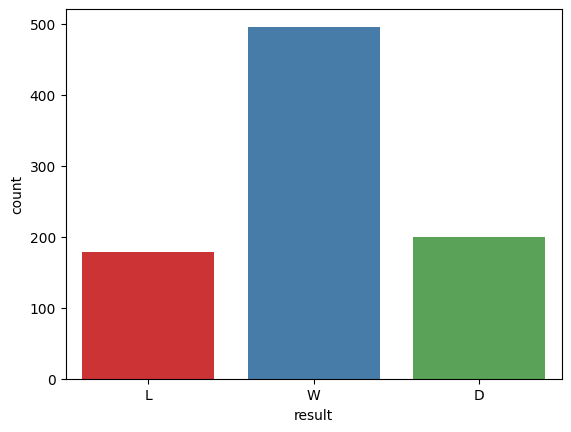

In [3]:
matches_df = matches_df.drop(
    columns=[
        "average_score_before_match_team1",
        "average_score_before_match_diff",
        "draw_percent_before_team2",
    ]
)

sns.countplot(x="result", data=matches_df, palette="Set1");

### Phân chia dữ liệu thành X, y

In [4]:
X = matches_df.drop("result", axis=1)
X.head()

,venue,season,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type,win_rate_type
0,Away,2000-2001,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,1500.000000,0.000000,0.000000,0,Weak Opponent,Diverse Win Rate
1,Home,2000-2001,1.000000,-1.000000,0.000000,0.0,0.0,0.0,1,1531.250000,-62.500000,3.000000,2,Strong Opponent,High Win Rate
2,Home,2000-2001,0.500000,0.000000,0.500000,0.0,0.0,0.0,0,1513.545664,-0.621645,1.500000,0,Weak Opponent,Diverse Win Rate
3,Away,2000-2001,0.333333,0.333333,0.333333,0.0,0.0,0.0,1,1507.852086,42.639029,1.333333,0,Weak Opponent,Diverse Win Rate
4,Away,2000-2001,0.250000,0.250000,0.500000,0.0,0.0,0.0,0,1456.587085,96.956843,1.000000,0,Weak Opponent,Diverse Win Rate


In [5]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(matches_df["result"])

In [6]:
# Xác định các cột phân loại và cột số
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop('Cluster')

numerical_cols, categorical_cols

(Index(['win_percent_before_team2', 'win_percent_diff',
        'lose_percent_before_team2', 'head2head_win_percent',
        'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
        'ELO_before_match_team2', 'ELO_before_diff',
        'average_score_before_match_team2'],
       dtype='object'),
 Index(['venue', 'season', 'match_type', 'win_rate_type'], dtype='object'))

#### Encoding cho các đặc trưng

In [7]:
X_no_cluster = X.drop(['Cluster', 'match_type'], axis=1)

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("venue", OneHotEncoder(use_cat_names=True), ["venue"]),
        ("season", BinaryEncoder(), ["season"]),
        ('num', StandardScaler(), numerical_cols),
    ]
)

transformed_X = preprocessor.fit_transform(X_no_cluster)

# Hiển thị dữ liệu sau khi tiền xử lý
columns = (
    list(preprocessor.named_transformers_["venue"].get_feature_names_out())
    + list(preprocessor.named_transformers_["season"].get_feature_names_out())
    + numerical_cols.tolist()
)

transformed_X = pd.DataFrame(transformed_X, columns=columns)
transformed_X.head()

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.362390,-0.520879,-1.435440,-1.948832,-1.169633,-0.973674,-0.595390,0.026422,-0.826088,-1.794548
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.376723,-3.368248,-1.435440,-1.948832,-1.169633,-0.973674,1.679572,0.155401,-1.022913,2.225725
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.507166,-0.520879,0.540040,-1.948832,-1.169633,-0.973674,-0.595390,0.082329,-0.828046,0.215589
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.116019,0.428244,-0.118454,-1.948832,-1.169633,-0.973674,1.679572,0.058830,-0.691810,-0.007760
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.427612,0.190964,0.540040,-1.948832,-1.169633,-0.973674,-0.595390,-0.152758,-0.520753,-0.454457


In [9]:
X_cluster = X[['Cluster', 'match_type', 'win_rate_type']]

In [10]:
preprocessor_for_clustering = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["Cluster"]),
        ("match_type", BinaryEncoder(), ["match_type"]),
        ("win_rate_type", BinaryEncoder(), ["win_rate_type"]),
    ]
)

transformed_X_for_clustering = preprocessor_for_clustering.fit_transform(X_cluster)

In [11]:
# Hiển thị dữ liệu sau khi tiền xử lý
columns_for_clustering = (
    ["Cluster"]
    + list(preprocessor_for_clustering.named_transformers_["match_type"].get_feature_names_out())
    + list(preprocessor_for_clustering.named_transformers_["win_rate_type"].get_feature_names_out())
)


transformed_X_clustering_df = pd.DataFrame(transformed_X_for_clustering, columns=columns_for_clustering)
transformed_X_clustering_df.head()

,Cluster,match_type_0,match_type_1,win_rate_type_0,win_rate_type_1
0,-1.119467,0.0,1.0,0.0,1.0
1,1.485675,1.0,0.0,1.0,0.0
2,-1.119467,0.0,1.0,0.0,1.0
3,-1.119467,0.0,1.0,0.0,1.0
4,-1.119467,0.0,1.0,0.0,1.0


In [12]:
transformed_X = pd.concat([transformed_X, transformed_X_clustering_df], axis=1)
transformed_X

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,...,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type_0,match_type_1,win_rate_type_0,win_rate_type_1
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.362390,-0.520879,-1.435440,...,-0.973674,-0.595390,0.026422,-0.826088,-1.794548,-1.119467,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.376723,-3.368248,-1.435440,...,-0.973674,1.679572,0.155401,-1.022913,2.225725,1.485675,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.507166,-0.520879,0.540040,...,-0.973674,-0.595390,0.082329,-0.828046,0.215589,-1.119467,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.116019,0.428244,-0.118454,...,-0.973674,1.679572,0.058830,-0.691810,-0.007760,-1.119467,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.427612,0.190964,0.540040,...,-0.973674,-0.595390,-0.152758,-0.520753,-0.454457,-1.119467,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,0.0,1.0,1.0,0.0,1.0,1.0,1.0,-1.362390,0.048595,1.725328,...,0.503041,1.679572,-0.145722,1.539203,-1.526529,0.183104,1.0,1.0,1.0,1.0
871,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.628900,-2.229301,-0.645248,...,0.010802,-0.595390,2.297142,-0.321636,1.421670,1.485675,1.0,0.0,1.0,0.0
872,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.881078,-1.090353,0.144944,...,0.995279,-0.595390,1.192365,0.690306,0.617616,-1.119467,0.0,1.0,0.0,1.0
873,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.133255,-0.520879,0.144944,...,-0.973674,-0.595390,-1.746270,2.673179,0.081580,-1.119467,0.0,1.0,0.0,1.0


In [13]:
X = transformed_X

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Huấn luyện mô hình với dữ liệu đã xử lý mất cân bằng
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.75      0.79       152
           1       0.78      0.77      0.77       147
           2       0.67      0.75      0.71       148

    accuracy                           0.76       447
   macro avg       0.76      0.76      0.76       447
weighted avg       0.76      0.76      0.76       447



Counter({1: 496, 2: 496, 0: 496})


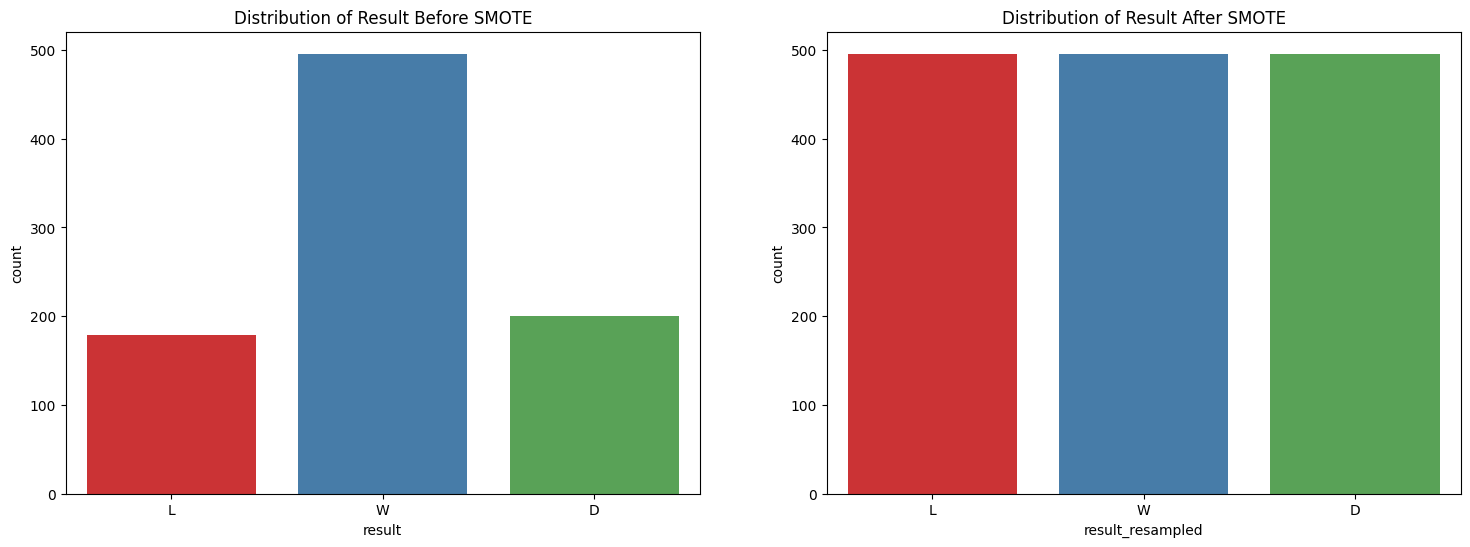

In [14]:
from collections import Counter

# Xem số lượng các giá trị trong y_resampled
counter = Counter(y_resampled)
print(counter)

# Vẽ biểu đồ phân phối của nhãn trước và sau khi áp dụng SMOTE trên cùng một figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Trước khi áp dụng SMOTE
sns.countplot(x="result", data=matches_df, palette="Set1", ax=axes[0])
axes[0].set_title('Distribution of Result Before SMOTE')

# Sau khi áp dụng SMOTE
resampled_df = pd.DataFrame(y_resampled, columns=["result_resampled"])
sns.countplot(x="result_resampled", data=resampled_df, palette="Set1", ax=axes[1])
axes[1].set_title('Distribution of Result After SMOTE')
axes[1].set_xticklabels(['L', 'W', 'D'])

plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Best parameters found: {grid_search.best_params_}')
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       152
           1       0.75      0.74      0.75       147
           2       0.65      0.75      0.70       148

    accuracy                           0.74       447
   macro avg       0.75      0.74      0.74       447
weighted avg       0.75      0.74      0.74       447



In [16]:
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Thử nghiệm với SVM
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print('SVM Classification Report:')
print(classification_report(y_test, y_pred_svc))

# Thử nghiệm với XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       152
           1       0.59      0.69      0.63       147
           2       0.61      0.51      0.56       148

    accuracy                           0.58       447
   macro avg       0.58      0.58      0.58       447
weighted avg       0.58      0.58      0.58       447

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       152
           1       0.75      0.73      0.74       147
           2       0.65      0.70      0.68       148

    accuracy                           0.72       447
   macro avg       0.73      0.72      0.72       447
weighted avg       0.73      0.72      0.72       447



In [17]:
from sklearn.model_selection import cross_val_score

# Đánh giá mô hình với cross-validation
cv_scores = cross_val_score(rf, transformed_X, y, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {cv_scores.mean()}')


Cross-validation scores: [0.57714286 0.61142857 0.58857143 0.57142857 0.48571429]
Average cross-validation score: 0.566857142857143


#### Note: Cell này dùng để thử nghiệm việc lựa chọn đặc trưng

In [10]:
matches_df = pd.read_csv("../../../data_for_training/arsenal.csv")
matches_df = matches_df.drop(
    columns=[
        "average_score_before_match_team1",
        "average_score_before_match_diff",
        "draw_percent_before_team2",
    ]
)

X = matches_df.drop("result", axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(matches_df["result"])

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("venue", OneHotEncoder(use_cat_names=True), ["venue"]),
        ("season", BinaryEncoder(), ["season"]),
        ('num', StandardScaler(), numerical_cols),
    ]
)

X = preprocessor.fit_transform(X)

# Hiển thị dữ liệu sau khi tiền xử lý
columns = (
    list(preprocessor.named_transformers_["venue"].get_feature_names_out())
    + list(preprocessor.named_transformers_["season"].get_feature_names_out())
    + numerical_cols.tolist()
)

X = pd.DataFrame(X, columns=columns)

### Thử nghiệm các mô hình

In [18]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed, class_weight="balanced")),
    (
        "SVC",
        SVC(
            probability=True,
            random_state=seed,
            class_weight="balanced",
        ),
    ),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed, class_weight="balanced")),
    (
        "SGDC",
        CalibratedClassifierCV(
            SGDClassifier(random_state=seed, class_weight="balanced")
        ),
    ),
    ("NB", GaussianNB()),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100, random_state=seed, class_weight="balanced"
        ),
    ),
]

cv_results = {}

for name, model in algorithms:
    # Thực hiện cross-validation
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=k_fold, scoring="accuracy")
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"Accuracy {name}: {score}")

Accuracy LR: 0.5080854344277163
Accuracy SVC: 0.6129874841284236
Accuracy KNN: 0.6774805006348631
Accuracy DTC: 0.6230273898059133
Accuracy SGDC: 0.4382006167241067
Accuracy NB: 0.4509477598403773
Accuracy RF: 0.7809767821512787


### Chọn bộ siêu tham số

#### RF

In [14]:
best_params_RF = {}
models_tuned_RF = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6],
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4, 6],
        "class_weight": ["balanced"]
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,
            cv=k_fold, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_RF[name] = randomized_search.best_params_
        models_tuned_RF[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  RF
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


## Thử nghiệm bộ tham số

#### Random forest

In [19]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(
        model, X_resampled, y_resampled, cv=k_fold, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"{name}: {score}")

RF: 0.786354979140214


## Test Vẽ ma trận nhầm lẫn của model có độ chính xác cao nhất

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed, stratify=y_resampled)

In [23]:
from sklearn.metrics import confusion_matrix

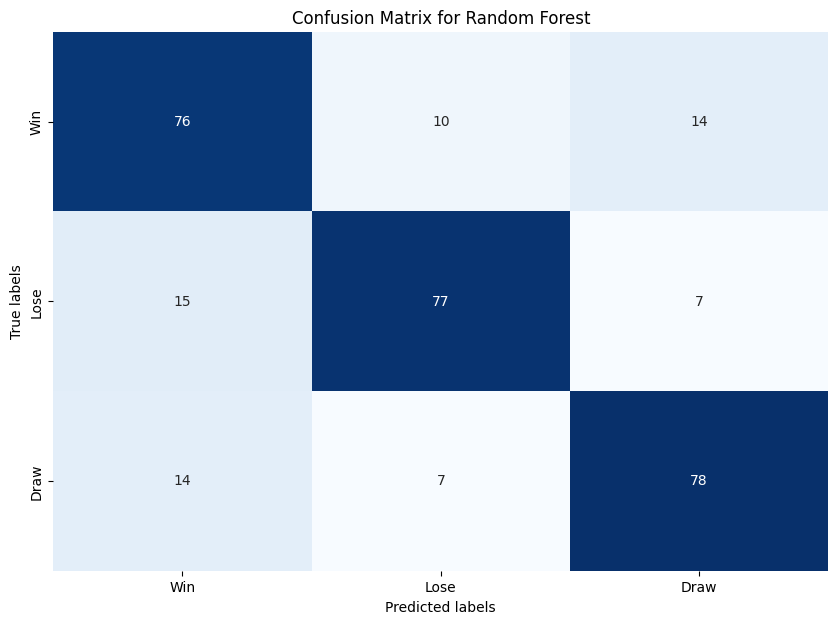

In [25]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)
    best_params_RF["RF"].pop("class_weight", None)

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]

cm_reordered = cm[desired_indices, :][:, desired_indices]
df_cm = pd.DataFrame(cm_reordered, index=desired_labels, columns=desired_labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [17]:
import pickle
def save_model(model, file_name):
    with open(file_name, "wb") as file:
        pickle.dump(model, file)

In [18]:
# Lưu các encoder
save_model(preprocessor, "final_model_clustered/preprocessor.pkl")

In [21]:
# Lưu các encoder
save_model(preprocessor_for_clustering, "final_model_clustered/preprocessor_clustering.pkl")

In [23]:
# Lưu model vào file joblib
import joblib

with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)
    best_params_RF["RF"]["class_weight"] = "balanced"

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)
rf_model.fit(X, y)

save_model(rf_model, "final_model_clustered/RF.pkl")

### Tạo model cho việc phân cụm

In [24]:
X_resampled.columns

Index(['venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2',
       'season_3', 'season_4', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2', 'Cluster', 'match_type_0',
       'match_type_1', 'win_rate_type_0', 'win_rate_type_1'],
      dtype='object')

In [25]:
from sklearn.cluster import KMeans
import pickle

# Loại bỏ các cột không phù hợp khỏi tập dữ liệu huấn luyện
X_train = X_resampled.drop(['match_type_0', 'match_type_1', 'win_rate_type_0', 'win_rate_type_1', 'Cluster'], axis=1)

# Huấn luyện mô hình KMeans mới
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train)

# Lưu mô hình phân cụm mới
with open("final_model_clustered/kmeans_model.pkl", "wb") as file:
    pickle.dump(kmeans, file)


In [14]:
preprocessor.feature_names_in_

array(['venue', 'season', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent',
       'is_opponent_big6', 'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2', 'win_rate_type'], dtype=object)

In [20]:
preprocessor_for_clustering.feature_names_in_

array(['Cluster', 'match_type', 'win_rate_type'], dtype=object)